#### **This notebook looks info the language feature difference**

**1) Language use**

In [5]:
import pandas as pd
import numpy as np
import datetime
import warnings
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as pltc
import sys
import os

import importlib

#### packages
import helper.strategy_helper as st
import helper.visualization as viz_hp
import helper.helper as hp
import helper.file_helper as file_hp
import config.config as config_hp
import helper.pandas_helper as pd_hp

#### **Load dataset**

In [30]:
importlib.reload(config_hp)

config = config_hp.config()
balanced = config['BALANCED']

positive_conv = balanced['balanced_pos_conversation']
df_pos = pd.read_pickle(positive_conv)

negative_conv = balanced['balanced_neg_conversation']
df_neg = pd.read_pickle(negative_conv)

df = df_pos.append(df_neg)

/tmp/ipykernel_347434/2584407693.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_pos.append(df_neg)


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2673091 entries, 118 to 4272295
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   tweet_text       object 
 1   conversation_id  object 
 2   replier_tweetid  object 
 3   replier_userid   object 
 4   poster_userid    object 
 5   poster_tweetid   object 
 6   tweet_time       object 
 7   tweet_language   object 
 8   replier_label    int64  
 9   year             object 
 10  campaign         object 
 11  tweet_label      int64  
 12  tweet_time_year  object 
 13  common           float64
dtypes: float64(1), int64(2), object(11)
memory usage: 305.9+ MB


##### **Just the IO reply**

In [32]:
# df_io = df.loc[df['tweet_label'] == 1]
# df_pc = df.loc[df['tweet_label'] == 0]

In [13]:
# df_pc.info()

#### **Any replier with more than two language**

In [33]:
def test_for_language(df, 
                      just_size=True):
    '''
    Gets accounts with more than 1 languages
    '''
    #ISO 639-2
    non_language = ['qam', #tweet with mention only
                    'qct', #tweet with cashtags only
                    'qht', #tweet with hashtags only
                    'qme', #tweet with media links only
                    'qst', #tweet with very short text
                    'zxx', #absense of language code
                    'und', #undetermined
                    # 'en'
                   ]
    df_lang = df.loc[
    ~df['tweet_language'].isin(non_language)]
    
    df_lang_count = (df_lang
           .groupby(['replier_userid'])['tweet_language']
           .nunique()
           .to_frame('lang_count')
            .reset_index()
            )
    
    df_test = df_lang_count.loc[df_lang_count['lang_count']>0] #['replier_userid

    print('Min count :', df_test['lang_count'].min())
    print('Max count :', df_test['lang_count'].max())
    
    if just_size == True:
        return df_test
    
    df_user = df.loc[df['replier_userid'].isin(df_test['replier_userid'])]
    df_user = df_user.loc[~df_user['tweet_language'].isin(non_language)]
    
    return (df_user, df_test)

In [34]:
data = [test_for_language(df_pos, just_size=True),
        test_for_language(df_neg, just_size=True)
       ]

Min count : 1
Max count : 9
Min count : 1
Max count : 9


In [35]:
import helper.stat_helper as stat_hp
importlib.reload(stat_hp)

stat_hp.KS_test(data[0]['lang_count'],
                data[1]['lang_count'])

KS test statistic: 0.0010358059701064404
p-value: 0.9756457128922035


In [25]:
### Not significantly different

#### **Number of languages used by each replier**

/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/language_reply_count.png
/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/language_reply_count.png


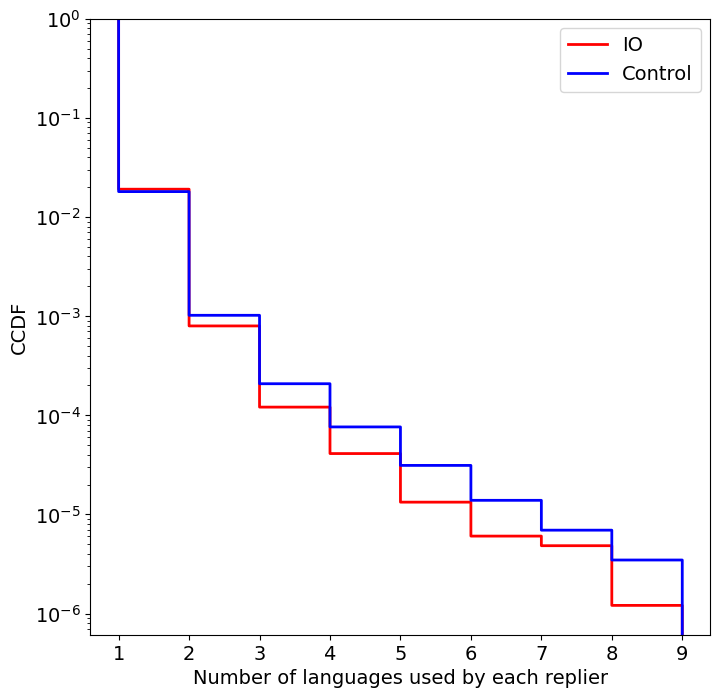

In [36]:
importlib.reload(config_hp)
importlib.reload(viz_hp)

config = config_hp.config()
plot_path = config['PLOTS']
reply_plot_path = plot_path['reply_plot_path']

parameters = {
        'data': data,
        'fontsize': 14,
        'complementary': True,
        'columns': [
            {'column': 'lang_count',
             'label': 'IO',
            },{
            'column': 'lang_count',
             'label': 'Control'
            },
        ],
        'xlabel': 'Number of languages used by each replier',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        'log_yscale': True,
        'log_xscale': False,
        'save': {
            'path': reply_plot_path,
            'filename': 'language_reply_count.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

#### **Language count per tweet**

In [37]:
def language_count_per_tweet(df_lang):
    '''
    Gets accounts with more than 1 languages
    '''
    
    non_language = ['qam', 'qct', 
                    'qht', 'qme', 
                    'qst', 'zxx',
                    'und', 
                    # 'en'
                   ]
    df_lang = df.loc[
    ~df['tweet_language'].isin(non_language)]
    
    df_lang_count = (df_lang
           .groupby(['poster_tweetid'])['tweet_language']
           .nunique()
           .to_frame('lang_count')
            .reset_index()
            )
    
    print('Min count :', df_lang_count['lang_count'].min())
    print('Max count :', df_lang_count['lang_count'].max())
    
    return df_lang_count

In [38]:
data = [language_count_per_tweet(df_pos),
        language_count_per_tweet(df_neg)]

Min count : 1
Max count : 37
Min count : 1
Max count : 37


In [39]:
from scipy.stats import ks_2samp
statistic, pvalue = ks_2samp(data[0]['lang_count'], 
                             data[1]['lang_count'])


print('KS test statistic:', statistic)
print('p-value:', pvalue)

#not statistically significant

KS test statistic: 0.0
p-value: 1.0


/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/language_count_per_tweet.png
/N/slate/potem/project/infoOps-strategy/plots/reply_characterization/language_count_per_tweet.png


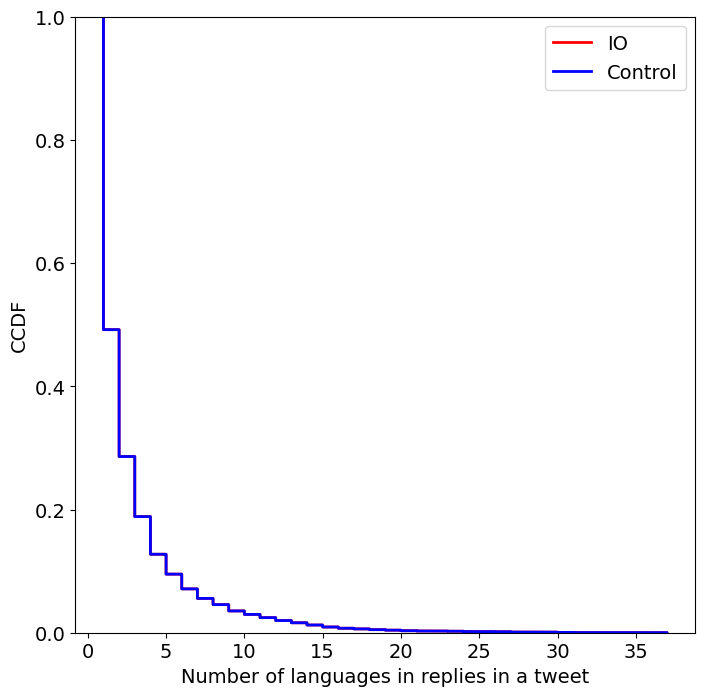

In [40]:
importlib.reload(config_hp)
importlib.reload(viz_hp)

config = config_hp.config()
plot_path = config['PLOTS']
reply_plot_path = plot_path['reply_plot_path']

parameters = {
        'data': data,
        'fontsize': 14,
        'complementary': True,
        'columns': [
            {'column': 'lang_count',
             'label': 'IO',
            },{
            'column': 'lang_count',
             'label': 'Control'
            },
        ],
        'xlabel': 'Number of languages in replies in a tweet',
        'ylabel': 'CDF',
        'legend_location': 'upper right',
        'log_yscale': False,
        'log_xscale': False,
        'save': {
            'path': reply_plot_path,
            'filename': 'language_count_per_tweet.png'
        },
        'random_color': False
}


viz_hp.ccdf(parameters)

#### **Create feature**

In [28]:
importlib.reload(config_hp)

config = config_hp.config()
balanced = config['BALANCED']

positive_replier = balanced['balanced_pos_replier']
df_pos = pd.read_pickle(positive_replier)

negative_replier = balanced['balanced_neg_replier']
df_neg = pd.read_pickle(negative_replier)

df = df_pos.append(df_neg)

/tmp/ipykernel_347434/3721289818.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df_pos.append(df_neg)
/tmp/ipykernel_347434/3721289818.py:12: FutureWarning: In a future version, object-dtype columns with all-bool values will not be included in reductions with bool_only=True. Explicitly cast to bool dtype instead.
  df = df_pos.append(df_neg)


In [62]:
df_pos['tweet_language'].unique()

array(['und', 'sl', 'cs', 'en', 'nl', 'es', 'sr', 'qme', 'tl', 'lt', 'lv',
       'tr', 'no', 'hu', 'ru', 'pl', 'in', 'pt', 'ar', 'et', 'it', 'ro',
       'fi', 'de', 'eu', 'fr', 'da', 'qam', 'ca', 'uk', 'ht', 'fa', 'bg',
       'is', 'sv', 'ja', 'ko', 'ur', 'vi', 'cy', 'hi', 'th', 'el', 'zh',
       'iw', 'sd', 'zxx', 'ta', 'qst', 'qht', 'ml', 'bn', 'ckb', 'ne',
       'ps', 'art', 'bs', 'hr', 0, 'sk'], dtype=object)

In [63]:
df_neg['tweet_language'].unique()

array(['und', 'qme', 'tr', 'en', 'in', 'is', 'qam', 'hu', 'de', 'ht',
       'nl', 'es', 'ro', 'et', 'fr', 'eu', 'it', 'sv', 'tl', 'fi', 'ar',
       'ca', 'sl', 'sr', 'lv', 'cs', 'pl', 'uk', 'bg', 'zxx', 'ru', 'lt',
       'th', 'zh', 'pt', 'no', 'hi', 'da', 'iw', 'ur', 'ja', 'fa', 'ko',
       'bn', 'cy', 'vi', 'am', 'ta', 'ps', 'ne', 'ckb', 'el', 'qst'],
      dtype=object)

In [64]:
data = [language_count_per_tweet(df_pos),
        language_count_per_tweet(df_neg)]

Min count : 1
Max count : 40
Min count : 1
Max count : 33


In [65]:
df_all = data[0].append(data[1])

df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7732 entries, 0 to 3865
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   poster_tweetid  7732 non-null   object
 1   lang_count      7732 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 181.2+ KB


/tmp/ipykernel_1381984/1310816458.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_all = data[0].append(data[1])


In [66]:
id_label = df[['poster_tweetid','tweet_label']].drop_duplicates()

df_stat = df_all.merge(id_label[['poster_tweetid','tweet_label']],
              on='poster_tweetid')

In [69]:
importlib.reload(config_hp)

config = config_hp.config()
stat = config['STATS']
language_count = stat['language_count']

df_stat.to_pickle(language_count)

#### **Run model test**

Index(['poster_tweetid', 'lang_count', 'tweet_label'], dtype='object')
Xtrain:  6185
Xtrain shape:  (6185, 1)
Xtest:  1547
Ytrain:  6185
Ytest:  1547
0.531285367825384
              precision    recall  f1-score   support

           0       0.52      0.50      0.51       773
           1       0.52      0.53      0.52       774

    accuracy                           0.52      1547
   macro avg       0.52      0.52      0.52      1547
weighted avg       0.52      0.52      0.52      1547

Cross validation: mean 0.52 accuracy with a standard deviation of 0.01
            Importance
Feature               
lang_count         1.0


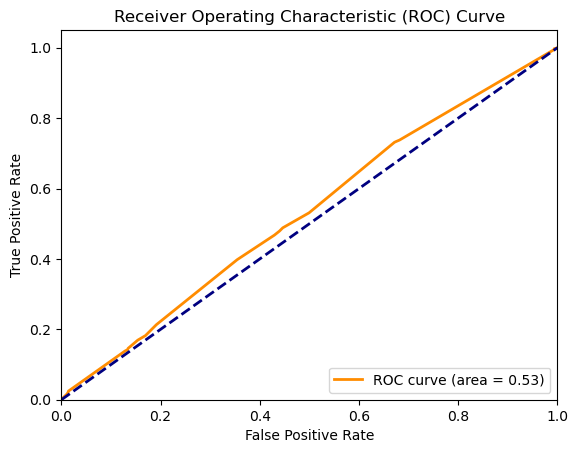

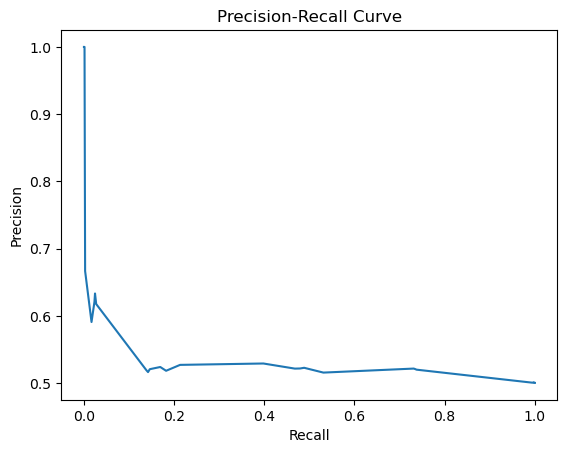

In [70]:
import helper.stat_helper as stat_hp
importlib.reload(stat_hp)

stat_hp.run_model(df_stat,
          columns_not_include=[]
         )